In [1]:
import pickle
from string import punctuation

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Load the data
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json

docs = db.read_text('../Data/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [3]:
docs.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

In [4]:
# Trimming the data
get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'doi': x['doi'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}

# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract']
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2019)
           .map(trim).
           compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [5]:
#save trimmed dataset for later use so we can skip the dataset trimming later:
docs_df.to_csv("../Data/trimmed_arxiv_docs.csv", index=False)

In [3]:
# Read docs from the file
docs_df = pd.read_csv('../Data/trimmed_arxiv_docs.csv')

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
#The first 5 rows:
docs_df.head()

,id,authors,title,doi,category,abstract
0,704.0479,T.Geisser,The affine part of the Picard scheme,NaN,"['math.AG', 'math.KT']",We describe the maximal torus and maximal un...
1,705.0825,Ram Gopal Vishwakarma (Zacatecas University),Einstein's Theory of Gravity in the Presence o...,10.1007/s10509-009-0016-8,"['gr-qc', 'astro-ph', 'hep-th']",The mysterious `dark energy' needed to expla...
2,705.4004,Samy Skander Bahoura (IMJ),About Brezis-Merle Problem with Lipschitz cond...,NaN,['math.AP'],We give blow-up analysis for a Brezis-Merle'...
3,705.406,Ruy Exel and Artur O. Lopes,C*- Algebras and Thermodynamic Formalism,NaN,"['math.DS', 'math.OA']",We present a detailed exposition (for a Dyna...
4,705.4151,"Maria Deijfen, Henri van den Esker, Remco van ...",A preferential attachment model with random in...,10.1007/s11512-007-0067-4,"['math.PR', 'math.CO']","In this paper, a random graph process ${G(t)..."


In [ ]:
# Listing categories
categories = list(docs_df['category'].unique())
for i in categories:
    print(i)
        

In [10]:
# Split categories
def splitCategory(cat):
    tmp = cat.replace('[','').replace(']','')
    c = tmp.split(', ')
    c = [w.replace("'","") for w in c]
    return c

In [11]:
# Find main category
def findMainCat(categories):
    new_cat = list(dict.fromkeys([cat.split(".")[0] for cat in categories]))
    return new_cat


Cleaning the data

In [4]:
df = pd.read_csv("../Data/trimmed_arxiv_docs.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377629 entries, 0 to 377628
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        377629 non-null  object
 1   authors   377629 non-null  object
 2   title     377629 non-null  object
 3   doi       117502 non-null  object
 4   category  377629 non-null  object
 5   abstract  377629 non-null  object
dtypes: object(6)
memory usage: 17.3+ MB


In [6]:
# Adding abstract word count
df['abstract_word_count'] = docs_df['abstract'].apply(lambda x: len(x.strip().split())) 

In [12]:
df['abstract'].describe(include='all')

count                                                377559
unique                                               377559
top         Let $G=(V,E)$ be a finite undirected graph. ...
freq                                                      1
Name: abstract, dtype: object

In [7]:
# Getting rid of duplicates
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                                377559
unique                                               377559
top         Let $G=(V,E)$ be a finite undirected graph. ...
freq                                                      1
Name: abstract, dtype: object

NLP data processing

In [13]:
# Add the categories
df['list_categories'] = df.category.apply(splitCategory)
df['main_categories'] = df.list_categories.apply(findMainCat)

In [14]:
df

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories
0,704.0479,T.Geisser,The affine part of the Picard scheme,NaN,"['math.AG', 'math.KT']",We describe the maximal torus and maximal un...,21,"[math.AG, math.KT]",[math]
1,705.0825,Ram Gopal Vishwakarma (Zacatecas University),Einstein's Theory of Gravity in the Presence o...,10.1007/s10509-009-0016-8,"['gr-qc', 'astro-ph', 'hep-th']",The mysterious `dark energy' needed to expla...,83,"[gr-qc, astro-ph, hep-th]","[gr-qc, astro-ph, hep-th]"
2,705.4004,Samy Skander Bahoura (IMJ),About Brezis-Merle Problem with Lipschitz cond...,NaN,['math.AP'],We give blow-up analysis for a Brezis-Merle'...,39,[math.AP],[math]
3,705.406,Ruy Exel and Artur O. Lopes,C*- Algebras and Thermodynamic Formalism,NaN,"['math.DS', 'math.OA']",We present a detailed exposition (for a Dyna...,110,"[math.DS, math.OA]",[math]
4,705.4151,"Maria Deijfen, Henri van den Esker, Remco van ...",A preferential attachment model with random in...,10.1007/s11512-007-0067-4,"['math.PR', 'math.CO']","In this paper, a random graph process ${G(t)...",152,"[math.PR, math.CO]",[math]
...,...,...,...,...,...,...,...,...,...
377624,quant-ph/0507088,Rahul Jain,Chain-rules for channel capacity,NaN,['quant-ph'],We show some chain-rules for the capacity of...,32,[quant-ph],[quant-ph]
377625,quant-ph/0604056,Scott Aaronson and Greg Kuperberg,Quantum Versus Classical Proofs and Advice,NaN,"['quant-ph', 'cs.CC']",This paper studies whether quantum proofs ar...,174,"[quant-ph, cs.CC]","[quant-ph, cs]"
377626,quant-ph/0612050,"Igor Devetak, Jon Yard",The exact cost of redistributing multipartite ...,10.1103/PhysRevLett.100.230501,['quant-ph'],How correlated are two quantum systems from ...,118,[quant-ph],[quant-ph]
377627,quant-ph/0701163,Daegene Song,Does Observation Create Reality?,NaN,['quant-ph'],It has been suggested that the locality of i...,112,[quant-ph],[quant-ph]


In [51]:
# Create CS and Random dataframes
bool_series = ["cs" in cat for cat in df.main_categories]
df_cs = df[bool_series]

In [52]:
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories
30,801.3697,George I. Bell,The mathematics of Septoku,NaN,"['math.CO', 'cs.DM', 'math.GM']",Septoku is a Sudoku variant invented by Bruc...,93,"[math.CO, cs.DM, math.GM]","[math, cs]"
39,805.1293,Avik Chakraborty,Testability of Reversible Iterative Logic Arrays,NaN,['cs.OH'],Iterative Logic Arrays (ILAs) are ideal as V...,227,[cs.OH],[cs]
43,806.0557,"Qin Li, Chengqing Li, Chunhui Wu, Dongyang Lon...",An efficient and provably secure arbitrated qu...,NaN,"['quant-ph', 'cs.CR']","In this paper, an efficient arbitrated quant...",120,"[quant-ph, cs.CR]","[quant-ph, cs]"
57,809.2093,"Troy Lee, Adi Shraibman",An approximation algorithm for approximation rank,NaN,['cs.CC'],One of the strongest techniques available fo...,188,[cs.CC],[cs]
65,810.484,"Dorit Aharonov, Michael Ben-Or, Fernando G.S.L...",The Pursuit of Uniqueness: Extending Valiant-V...,NaN,"['quant-ph', 'cs.CC']",Valiant-Vazirani showed in 1985 [VV85] that ...,195,"[quant-ph, cs.CC]","[quant-ph, cs]"
...,...,...,...,...,...,...,...,...,...
377513,cs/0606037,Andrej Bogdanov and Luca Trevisan,Average-Case Complexity,NaN,['cs.CC'],We survey the average-case complexity of pro...,170,[cs.CC],[cs]
377514,cs/0608050,Pascal Pons and Matthieu Latapy,Post-Processing Hierarchical Community Structu...,10.1016/j.tcs.2010.11.041,"['cs.DS', 'cond-mat.dis-nn', 'physics.soc-ph']",Dense sub-graphs of sparse graphs (communiti...,122,"[cs.DS, cond-mat.dis-nn, physics.soc-ph]","[cs, cond-mat, physics]"
377515,cs/0610128,Daniel Lemire and Owen Kaser,Hierarchical Bin Buffering: Online Local Momen...,10.1145/1328911.1328925,"['cs.DS', 'cs.DB']","Local moments are used for local regression,...",184,"[cs.DS, cs.DB]",[cs]
377547,math/0008020,Matthieu Latapy and Thi Ha Duong Phan,The Lattice of integer partitions and its infi...,10.1016/j.disc.2008.02.002,"['math.CO', 'cs.NA', 'math.DS', 'math.NA', 'ma...","In this paper, we use a simple discrete dyna...",152,"[math.CO, cs.NA, math.DS, math.NA, math.NT]","[math, cs]"


In [53]:
# Non-CS df
bool_series = ["cs" not in cat for cat in df.main_categories]
df_random = df[bool_series]

In [54]:
df_random

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories
0,704.0479,T.Geisser,The affine part of the Picard scheme,NaN,"['math.AG', 'math.KT']",We describe the maximal torus and maximal un...,21,"[math.AG, math.KT]",[math]
1,705.0825,Ram Gopal Vishwakarma (Zacatecas University),Einstein's Theory of Gravity in the Presence o...,10.1007/s10509-009-0016-8,"['gr-qc', 'astro-ph', 'hep-th']",The mysterious `dark energy' needed to expla...,83,"[gr-qc, astro-ph, hep-th]","[gr-qc, astro-ph, hep-th]"
2,705.4004,Samy Skander Bahoura (IMJ),About Brezis-Merle Problem with Lipschitz cond...,NaN,['math.AP'],We give blow-up analysis for a Brezis-Merle'...,39,[math.AP],[math]
3,705.406,Ruy Exel and Artur O. Lopes,C*- Algebras and Thermodynamic Formalism,NaN,"['math.DS', 'math.OA']",We present a detailed exposition (for a Dyna...,110,"[math.DS, math.OA]",[math]
4,705.4151,"Maria Deijfen, Henri van den Esker, Remco van ...",A preferential attachment model with random in...,10.1007/s11512-007-0067-4,"['math.PR', 'math.CO']","In this paper, a random graph process ${G(t)...",152,"[math.PR, math.CO]",[math]
...,...,...,...,...,...,...,...,...,...
377623,quant-ph/0411039,Sofia Wechsler,What was in the apparatus before the click,NaN,['quant-ph'],When a quantum system is described by a wave...,144,[quant-ph],[quant-ph]
377624,quant-ph/0507088,Rahul Jain,Chain-rules for channel capacity,NaN,['quant-ph'],We show some chain-rules for the capacity of...,32,[quant-ph],[quant-ph]
377626,quant-ph/0612050,"Igor Devetak, Jon Yard",The exact cost of redistributing multipartite ...,10.1103/PhysRevLett.100.230501,['quant-ph'],How correlated are two quantum systems from ...,118,[quant-ph],[quant-ph]
377627,quant-ph/0701163,Daegene Song,Does Observation Create Reality?,NaN,['quant-ph'],It has been suggested that the locality of i...,112,[quant-ph],[quant-ph]


In [55]:
# Reduce the size of the data
df_cs = df_cs.sample(10000, random_state=42)
df_random = df_random.sample(10000, random_state=42)

In [56]:
#Define stopwords (scientific stopwords)
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = STOP_WORDS

In [57]:
#Define the cleaner - remove punctuation and stopwords
def cleanPunct(text):
    return [w for w in text if w not in punctuation]

In [58]:
# make everything lowercase
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def low(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in ["(", ")"]]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miamijovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [59]:
# Create column with lowercase text
df_cs['cleaned'] = df_cs.abstract.apply(low)
df_random['cleaned'] = df_random.abstract.apply(low)


In [60]:
# Make ngrams
from nltk.util import ngrams

def bigrams(arr):
    return list(ngrams(arr, 2))

def trigrams(arr):
    return list(ngrams(arr,3))

In [61]:
#apply cleaning punctiation on unigrams
df_cs['cleaned'] = df_cs.cleaned.apply(cleanPunct)
df_random['cleaned'] = df_random.cleaned.apply(cleanPunct)
# Creating ngrams
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)


In [62]:
# View dataframe
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories,cleaned,bigrams,trigrams
92635,2004.03874,Italo Atzeni and Marco Maso,Full-Duplex Radios for Edge Caching,NaN,"['cs.IT', 'math.IT']",This chapter focuses on the performance enha...,271,"[cs.IT, math.IT]","[cs, math]","[this, chapter, focuses, on, the, performance,...","[(this, chapter), (chapter, focuses), (focuses...","[(this, chapter, focuses), (chapter, focuses, ..."
160796,2008.09084,Devendra Singh Sachan and Yuhao Zhang and Peng...,Do Syntax Trees Help Pre-trained Transformers ...,NaN,['cs.CL'],Much recent work suggests that incorporating...,193,[cs.CL],[cs],"[much, recent, work, suggests, that, incorpora...","[(much, recent), (recent, work), (work, sugges...","[(much, recent, work), (recent, work, suggests..."
304315,2106.02562,Zhaoxin Luo and Michael Zhu,Recurrent Neural Networks with Mixed Hierarchi...,NaN,['cs.CL'],Hierarchical structures exist in both lingui...,160,[cs.CL],[cs],"[hierarchical, structures, exist, in, both, li...","[(hierarchical, structures), (structures, exis...","[(hierarchical, structures, exist), (structure..."
21770,1905.04523,"Supritam Bhattacharjee, Devraj Mandal, Soma Bi...",Multi-class Novelty Detection Using Mix-up Tec...,NaN,['cs.CV'],Multi-class novelty detection is increasingl...,245,[cs.CV],[cs],"[multi-class, novelty, detection, is, increasi...","[(multi-class, novelty), (novelty, detection),...","[(multi-class, novelty, detection), (novelty, ..."
122056,2006.03552,"Ian Abraham, Ahalya Prabhakar and Todd D. Murphey",An Ergodic Measure for Active Learning From Eq...,NaN,['cs.RO'],This paper develops KL-Ergodic Exploration f...,174,[cs.RO],[cs],"[this, paper, develops, kl-ergodic, exploratio...","[(this, paper), (paper, develops), (develops, ...","[(this, paper, develops), (paper, develops, kl..."
...,...,...,...,...,...,...,...,...,...,...,...,...
244932,2102.04454,"Mohammadreza Zandehshahvar, Yashar Kiarashi, M...",Manifold Learning for Knowledge Discovery and ...,NaN,"['physics.optics', 'cs.LG']","Here, we present a new approach based on man...",100,"[physics.optics, cs.LG]","[physics, cs]","[here, we, present, a, new, approach, based, o...","[(here, we), (we, present), (present, a), (a, ...","[(here, we, present), (we, present, a), (prese..."
358175,2109.11365,"Xiaoran Wu, Jia Jia",Tumera: Tutor of Photography Beginners,NaN,['cs.HC'],With the popularity of photographic equipmen...,126,[cs.HC],[cs],"[with, the, popularity, of, photographic, equi...","[(with, the), (the, popularity), (popularity, ...","[(with, the, popularity), (the, popularity, of..."
201886,2011.05149,Eva van Weenen and Stefan Feuerriegel,Estimating Risk-Adjusted Hospital Performance,NaN,"['stat.AP', 'cs.AI', 'cs.LG']",The quality of healthcare provided by hospit...,253,"[stat.AP, cs.AI, cs.LG]","[stat, cs]","[the, quality, of, healthcare, provided, by, h...","[(the, quality), (quality, of), (of, healthcar...","[(the, quality, of), (quality, of, healthcare)..."
82646,2003.083,"Ali Baheri, Ilya Kolmanovsky, Anouck Girard, H...",Vision-Based Autonomous Driving: A Model Learn...,NaN,"['eess.SY', 'cs.SY', 'eess.SP']",We present an integrated approach for percep...,166,"[eess.SY, cs.SY, eess.SP]","[eess, cs]","[we, present, an, integrated, approach, for, p...","[(we, present), (present, an), (an, integrated...","[(we, present, an), (present, an, integrated),..."


In [63]:
def hyphenate(words, n):
    if(n==2):
        return [w[0]+'-'+w[1] for w in words]
    if(n==3):
        return [w[0]+'-'+w[1]+'-'+w[2] for w in words]

Dictionaties and most frequent term analysis

In [64]:
# Create dict func
def createDict(data):
    vocab = {}
    for instance in data:
        d = Counter(instance)
        for w in d.keys():
            if w in vocab:
                vocab[w] += d[w]
            else:
                vocab[w] = d[w]
    return dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))

In [65]:
from collections import Counter
unigram_cs = createDict(df_cs['cleaned'])
bigram_cs = createDict(df_cs['bigrams'])
trigram_cs = createDict(df_cs['trigrams'])

unigram_rand = createDict(df_random['cleaned'])
bigram_rand = createDict(df_random['bigrams'])
trigram_rand = createDict(df_random['trigrams'])

In [66]:
print(len(trigram_cs))

1235555


In [67]:
# Removing stopwords and punctuation
def clean(text):
    return [w for w in text if w not in punctuation and w not in stopwords]

In [68]:
df_cs['cleaned'] = df_cs.cleaned.apply(clean)
df_random['cleaned'] = df_random.cleaned.apply(clean)
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)

In [69]:
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories,cleaned,bigrams,trigrams
92635,2004.03874,Italo Atzeni and Marco Maso,Full-Duplex Radios for Edge Caching,NaN,"['cs.IT', 'math.IT']",This chapter focuses on the performance enha...,271,"[cs.IT, math.IT]","[cs, math]","[chapter, focuses, performance, enhancement, b...","[(chapter, focuses), (focuses, performance), (...","[(chapter, focuses, performance), (focuses, pe..."
160796,2008.09084,Devendra Singh Sachan and Yuhao Zhang and Peng...,Do Syntax Trees Help Pre-trained Transformers ...,NaN,['cs.CL'],Much recent work suggests that incorporating...,193,[cs.CL],[cs],"[recent, work, suggests, incorporating, syntax...","[(recent, work), (work, suggests), (suggests, ...","[(recent, work, suggests), (work, suggests, in..."
304315,2106.02562,Zhaoxin Luo and Michael Zhu,Recurrent Neural Networks with Mixed Hierarchi...,NaN,['cs.CL'],Hierarchical structures exist in both lingui...,160,[cs.CL],[cs],"[hierarchical, structures, exist, linguistics,...","[(hierarchical, structures), (structures, exis...","[(hierarchical, structures, exist), (structure..."
21770,1905.04523,"Supritam Bhattacharjee, Devraj Mandal, Soma Bi...",Multi-class Novelty Detection Using Mix-up Tec...,NaN,['cs.CV'],Multi-class novelty detection is increasingl...,245,[cs.CV],[cs],"[multi-class, novelty, detection, increasingly...","[(multi-class, novelty), (novelty, detection),...","[(multi-class, novelty, detection), (novelty, ..."
122056,2006.03552,"Ian Abraham, Ahalya Prabhakar and Todd D. Murphey",An Ergodic Measure for Active Learning From Eq...,NaN,['cs.RO'],This paper develops KL-Ergodic Exploration f...,174,[cs.RO],[cs],"[paper, develops, kl-ergodic, exploration, equ...","[(paper, develops), (develops, kl-ergodic), (k...","[(paper, develops, kl-ergodic), (develops, kl-..."
...,...,...,...,...,...,...,...,...,...,...,...,...
244932,2102.04454,"Mohammadreza Zandehshahvar, Yashar Kiarashi, M...",Manifold Learning for Knowledge Discovery and ...,NaN,"['physics.optics', 'cs.LG']","Here, we present a new approach based on man...",100,"[physics.optics, cs.LG]","[physics, cs]","[present, new, approach, based, manifold, lear...","[(present, new), (new, approach), (approach, b...","[(present, new, approach), (new, approach, bas..."
358175,2109.11365,"Xiaoran Wu, Jia Jia",Tumera: Tutor of Photography Beginners,NaN,['cs.HC'],With the popularity of photographic equipmen...,126,[cs.HC],[cs],"[popularity, photographic, equipment, people, ...","[(popularity, photographic), (photographic, eq...","[(popularity, photographic, equipment), (photo..."
201886,2011.05149,Eva van Weenen and Stefan Feuerriegel,Estimating Risk-Adjusted Hospital Performance,NaN,"['stat.AP', 'cs.AI', 'cs.LG']",The quality of healthcare provided by hospit...,253,"[stat.AP, cs.AI, cs.LG]","[stat, cs]","[quality, healthcare, provided, hospitals, sub...","[(quality, healthcare), (healthcare, provided)...","[(quality, healthcare, provided), (healthcare,..."
82646,2003.083,"Ali Baheri, Ilya Kolmanovsky, Anouck Girard, H...",Vision-Based Autonomous Driving: A Model Learn...,NaN,"['eess.SY', 'cs.SY', 'eess.SP']",We present an integrated approach for percep...,166,"[eess.SY, cs.SY, eess.SP]","[eess, cs]","[present, integrated, approach, perception, co...","[(present, integrated), (integrated, approach)...","[(present, integrated, approach), (integrated,..."


In [70]:
unigram_cs = createDict(df_cs['cleaned'])
bigram_cs = createDict(df_cs['bigrams'])
trigram_cs = createDict(df_cs['trigrams'])

unigram_rand = createDict(df_random['cleaned'])
bigram_rand = createDict(df_random['bigrams'])
trigram_rand = createDict(df_random['trigrams'])

In [ ]:
print(trigram_cs)

#trigrams - 20+
#bigrams - 40+
#unigrams - quite irrelevant, but maybe 100+

In [71]:
# Trim ngrams 
def trim(d, num):
    return dict((k, v) for k, v in d.items() if v>=num)

In [72]:
trim_value = 10
unigram_cs = trim(unigram_cs, trim_value)
unigram_rand = trim(unigram_rand, trim_value)
bigram_cs = trim(bigram_cs, trim_value)
bigram_rand = trim(bigram_rand, trim_value)
trigram_cs = trim(trigram_cs, trim_value)
trigram_rand = trim(trigram_rand, trim_value)

In [73]:
print(len(trigram_rand))

260


In [74]:
# Filter out dataframe, leave only ngrams from the list + hyphenate
def filterOutUniCs(words):
    return [w for w in words if w in unigram_cs]
def filterOutBiCs(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_cs]
def filterOutTriCs(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_cs]
def filterOutUniRand(words):
    return [w for w in words if w in unigram_rand]
def filterOutBiRand(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_rand]
def filterOutTriRand(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_rand]

In [75]:
df_cs.cleaned = df_cs.cleaned.apply(filterOutUniCs)
df_cs.bigrams = df_cs.bigrams.apply(filterOutBiCs)
df_cs.trigrams = df_cs.trigrams.apply(filterOutTriCs)

df_random.cleaned = df_random.cleaned.apply(filterOutUniRand)
df_random.bigrams = df_random.bigrams.apply(filterOutBiRand)
df_random.trigrams = df_random.trigrams.apply(filterOutTriRand)


In [156]:
df_cs

,id,authors,title,doi,category,abstract,abstract_word_count,list_categories,main_categories,cleaned,bigrams,trigrams
92635,2004.03874,Italo Atzeni and Marco Maso,Full-Duplex Radios for Edge Caching,NaN,"['cs.IT', 'math.IT']",This chapter focuses on the performance enha...,271,"[cs.IT, math.IT]","[cs, math]","[chapter, focuses, performance, enhancement, b...","[significantly-reduced, network-edge, base-sta...",[]
160796,2008.09084,Devendra Singh Sachan and Yuhao Zhang and Peng...,Do Syntax Trees Help Pre-trained Transformers ...,NaN,['cs.CL'],Much recent work suggests that incorporating...,193,[cs.CL],[cs],"[recent, work, suggests, incorporating, syntax...","[recent-work, work-suggests, transformer-model...","[named-entity-recognition, graph-neural-network]"
304315,2106.02562,Zhaoxin Luo and Michael Zhu,Recurrent Neural Networks with Mixed Hierarchi...,NaN,['cs.CL'],Hierarchical structures exist in both lingui...,160,[cs.CL],[cs],"[hierarchical, structures, exist, linguistics,...","[natural-language, language-processing, proces...","[natural-language-processing, language-process..."
21770,1905.04523,"Supritam Bhattacharjee, Devraj Mandal, Soma Bi...",Multi-class Novelty Detection Using Mix-up Tec...,NaN,['cs.CV'],Multi-class novelty detection is increasingl...,245,[cs.CV],[cs],"[multi-class, novelty, detection, increasingly...","[increasingly-important, area-research, increa...","[extensive-experiments-benchmark, experiments-..."
122056,2006.03552,"Ian Abraham, Ahalya Prabhakar and Todd D. Murphey",An Ergodic Measure for Active Learning From Eq...,NaN,['cs.RO'],This paper develops KL-Ergodic Exploration f...,174,[cs.RO],[cs],"[paper, develops, exploration, equilibrium, \t...","[paper-develops, robotic-systems, robotic-syst...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...
244932,2102.04454,"Mohammadreza Zandehshahvar, Yashar Kiarashi, M...",Manifold Learning for Knowledge Discovery and ...,NaN,"['physics.optics', 'cs.LG']","Here, we present a new approach based on man...",100,"[physics.optics, cs.LG]","[physics, cs]","[present, new, approach, based, manifold, lear...","[present-new, new-approach, approach-based, ma...",[]
358175,2109.11365,"Xiaoran Wu, Jia Jia",Tumera: Tutor of Photography Beginners,NaN,['cs.HC'],With the popularity of photographic equipmen...,126,[cs.HC],[cs],"[popularity, equipment, people, starting, lear...","[help-improve, different-aspects, allows-users...",[]
201886,2011.05149,Eva van Weenen and Stefan Feuerriegel,Estimating Risk-Adjusted Hospital Performance,NaN,"['stat.AP', 'cs.AI', 'cs.LG']",The quality of healthcare provided by hospit...,253,"[stat.AP, cs.AI, cs.LG]","[stat, cs]","[quality, healthcare, provided, hospitals, sub...","[generalized-linear, linear-model, work-propos...","[work-propose-novel, propose-novel-method, neu..."
82646,2003.083,"Ali Baheri, Ilya Kolmanovsky, Anouck Girard, H...",Vision-Based Autonomous Driving: A Model Learn...,NaN,"['eess.SY', 'cs.SY', 'eess.SP']",We present an integrated approach for percep...,166,"[eess.SY, cs.SY, eess.SP]","[eess, cs]","[present, integrated, approach, perception, co...","[autonomous-vehicle, demonstrate-approach, lea...","[deep-learning-algorithms, recurrent-neural-ne..."


Feature Selection on CS vs Random

In [77]:
#CHI-Square stastic where:
# a - number of times t and c co-occur 11
# b - number of times t occurs w/o c 10
# c - number of times c occurs w/o t 01
# d - number of times neither c nor t occur 00
def chi_square(n,a,b,c,d):
    return n*((a*d-c*b)**2)/((a+c)*(b+d)*(a+b)*(c+d))

In [78]:
def selectKbest(features, k):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in list(features)[:k]}
    return features

In [79]:
def findOccurrences(term, C, notC):
    a = 0
    b = 0
    c = 0
    d = 0
    for item in C:
        if term in item:
            a += 1
        else:
            c += 1
    for item in notC:
        if term in item:
            b += 1
        else:
            d += 1
    return a,b,c,d


In [95]:
# Calculate chi2 values for each word
from collections import Counter

def createTermLists(cat, nonCat):
    # Find number of times term and class co-occur
    wordsC = Counter()
    for items in cat:
        wordsC = wordsC + Counter(items)
    return wordsC


In [93]:
def findChiValues(cat, nonCat):
    wordsC = createTermLists(cat, nonCat)
    chi_values = {}
    for term in wordsC:
        a,b,c,d = findOccurrences(term, cat, nonCat)
        n = len(cat) + len(nonCat)
        chi_values[term] = chi_square(n, a, b, c, d)
    return chi_values

In [96]:
chi_values_uni = findChiValues(df_cs.cleaned, df_random.cleaned)

In [97]:
# Select k best terms
k = 260
k_best_uni = selectKbest(chi_values_uni, k)
print(k_best_uni)

{'learning': 3074.555727628824, 'performance': 2010.4689464368037, 'propose': 1983.241364151793, 'training': 1730.4314799450503, 'neural': 1683.8631816980946, 'network': 1675.0816596235015, 'proposed': 1493.1499893307441, 'state-of-the-art': 1458.8801792902048, 'networks': 1319.256899424778, 'datasets': 1308.4952885159469, 'tasks': 1274.162310277148, 'paper': 1270.8325912890202, 'deep': 1270.7254235896041, 'methods': 1180.2468065922649, 'task': 1163.6485800431856, 'dataset': 1015.9301079371821, 'novel': 974.2526276775709, 'algorithm': 963.961135042794, 'algorithms': 948.0219606621092, 'data': 904.7918254168274, 'quantum': 891.0567042852821, 'existing': 885.0343032624083, 'problem': 848.6676126648457, 'information': 778.8527239955812, 'accuracy': 751.715600216933, 'experiments': 729.9527319418962, 'trained': 721.9994159707878, 'image': 714.1670870478893, 'learn': 698.6483803885063, 'machine': 694.5127933736717, 'method': 691.5837757604637, 'outperforms': 687.7806432287872, 'research': 6

In [98]:
chi_values_bi = findChiValues(df_cs.bigrams, df_random.bigrams)
chi_values_tri = findChiValues(df_cs.trigrams, df_random.trigrams)

k_best_bi = selectKbest(chi_values_bi, k)
k_best_tri = selectKbest(chi_values_tri, k)

In [99]:
print(k_best_bi)

{'neural-networks': 811.6173060708263, 'neural-network': 704.1825505378162, 'deep-learning': 644.1259065033398, 'paper-propose': 591.7812931961296, 'machine-learning': 532.332667763701, 'propose-novel': 527.644296673662, 'deep-neural': 392.3059543115472, 'extensive-experiments': 389.4382709756346, 'experimental-results': 385.6066652923337, 'reinforcement-learning': 368.3673469387755, 'proposed-method': 356.3911265882768, 'available-https': 315.91243841739043, 'convolutional-neural': 310.97700597938973, 'magnetic-field': 299.18259134713094, 'training-data': 295.06970207017906, 'natural-language': 278.8339670468948, 'state-of-the-art-methods': 229.60602842259647, 'demonstrate-effectiveness': 221.42459936302512, 'paper-proposes': 218.32825719120135, 'learning-models': 211.22810023629887, 'code-available': 211.20711434490426, 'computer-vision': 208.14388198443973, 'outperforms-state-of-the-art': 197.9398101393658, 'proposed-approach': 184.6292204856292, 'work-propose': 177.48653946094532, 

In [100]:
print(k_best_tri)

{'deep-neural-networks': 307.66106513682286, 'paper-propose-novel': 160.2741797288443, 'convolutional-neural-networks': 155.40651231961044, 'code-available-https': 155.19500151163962, 'convolutional-neural-network': 153.435194534182, 'natural-language-processing': 150.11838194549392, 'machine-learning-models': 114.65352509303027, 'reinforcement-learning-rl': 107.5755290805811, 'deep-learning-models': 106.56479340504674, 'deep-reinforcement-learning': 103.53319595918983, 'deep-neural-network': 101.3173157037755, 'experimental-results-demonstrate': 99.49248781468268, 'generative-adversarial-networks': 85.36279186542806, 'neural-networks-cnns': 79.313287485568, 'neural-network-cnn': 79.313287485568, 'neural-networks-dnns': 78.30539102499749, 'machine-learning-ml': 78.30539102499749, 'graph-neural-networks': 74.2748168222423, 'recurrent-neural-network': 71.25294796527673, 'artificial-intelligence-ai': 67.22520443485676, 'deep-learning-based': 64.20545746388443, 'demonstrate-effectiveness-p

In [103]:
# Filter by chi value chiVal
def selectChiBest(features, chiVal):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in features if features[a]>chiVal}
    return features

In [104]:
chiVal = 40
chi_best_uni = selectChiBest(chi_values_uni, chiVal)
chi_best_bi = selectChiBest(chi_values_bi, chiVal)
chi_best_tri = selectChiBest(chi_values_tri, chiVal)

print(chi_best_tri)

{'deep-neural-networks': 307.66106513682286, 'paper-propose-novel': 160.2741797288443, 'convolutional-neural-networks': 155.40651231961044, 'code-available-https': 155.19500151163962, 'convolutional-neural-network': 153.435194534182, 'natural-language-processing': 150.11838194549392, 'machine-learning-models': 114.65352509303027, 'reinforcement-learning-rl': 107.5755290805811, 'deep-learning-models': 106.56479340504674, 'deep-reinforcement-learning': 103.53319595918983, 'deep-neural-network': 101.3173157037755, 'experimental-results-demonstrate': 99.49248781468268, 'generative-adversarial-networks': 85.36279186542806, 'neural-networks-cnns': 79.313287485568, 'neural-network-cnn': 79.313287485568, 'neural-networks-dnns': 78.30539102499749, 'machine-learning-ml': 78.30539102499749, 'graph-neural-networks': 74.2748168222423, 'recurrent-neural-network': 71.25294796527673, 'artificial-intelligence-ai': 67.22520443485676, 'deep-learning-based': 64.20545746388443, 'demonstrate-effectiveness-p

In [128]:
# Make unified df
df_combined = df_cs[['abstract', 'list_categories', 'main_categories']].copy()
df_tmp = df_random[['abstract', 'list_categories', 'main_categories']].copy()
df_combined = df_combined.append(df_tmp)

df_combined

,abstract,list_categories,main_categories
92635,This chapter focuses on the performance enha...,"[cs.IT, math.IT]","[cs, math]"
160796,Much recent work suggests that incorporating...,[cs.CL],[cs]
304315,Hierarchical structures exist in both lingui...,[cs.CL],[cs]
21770,Multi-class novelty detection is increasingl...,[cs.CV],[cs]
122056,This paper develops KL-Ergodic Exploration f...,[cs.RO],[cs]
...,...,...,...
185341,Quantum impurities serve as in-situ probes o...,[cond-mat.str-el],[cond-mat]
13291,We prove a general result about the stabilit...,[math.DG],[math]
231869,We consider quantum stochastic processes and...,"[cond-mat.stat-mech, quant-ph]","[cond-mat, quant-ph]"
11282,In this paper we study ideals arising from m...,"[math.AC, math.ST, stat.TH]","[math, stat]"


In [153]:
# Filter
def filterAbstract(text, chi_best_bi, chi_best_tri):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens if w not in punctuation]
    # Find trigrams
    i = 0
    new1 = []
    while(i<len(tokens)-2):
        trigram = tokens[i]+'-'+tokens[i+1]+'-'+tokens[i+2]
        if(trigram in chi_best_tri):
            new1.append(trigram)
            i += 3
        else:
            new1.append(tokens[i])
            i += 1
    
    #Find bigrams
    i = 0
    new2 = []
    while(i<len(new1)-1):
        bigram = new1[i]+'-'+new1[i+1]
        if(bigram in chi_best_bi):
            new2.append(bigram)
            i += 2
        else:
            new2.append(new1[i])
            i += 1

    return new2


In [154]:
df_combined['filteredAbstracts'] = df_combined.abstract.apply(filterAbstract, chi_best_bi = chi_best_bi, chi_best_tri = chi_best_tri)

In [157]:
print(list(df_combined.filteredAbstracts.head(3)))

[['this', 'chapter', 'focuses', 'on', 'the', 'performance', 'enhancement', 'brought', 'by', 'the', 'addition', 'of', 'caching', 'capabilities', 'to', 'full-duplex', 'fd', 'radios', 'in', 'the', 'context', 'of', 'ultra-dense', 'networks', 'udns', 'more', 'specifically', 'we', 'aim', 'at', 'showing', 'that', 'the', 'interference', 'footprint', 'of', 'such', 'networks', 'i.e.', 'the', 'major', 'bottleneck', 'to', 'overcome', 'to', 'observe', 'the', 'theoretical', 'fd', 'throughput', 'doubling', 'at', 'the', 'network', 'level', 'can', 'be', 'significantly', 'reduced', 'thanks', 'to', 'edge', 'caching', 'fundamental', 'results', 'show', 'that', 'most', 'of', 'the', 'gain', 'as', 'compared', 'to', 'their', 'half-duplex', 'hd', 'counterparts', 'can', 'be', 'achieved', 'by', 'such', 'networks', 'only', 'if', 'costly', 'modifications', 'to', 'their', 'infrastructure', 'are', 'performed', 'and/or', 'if', 'high-rate', 'signaling', 'is', 'exchanged', 'between', 'user', 'equipments', 'ues', 'over',

In [161]:
# Make a list of unified abstracts
abstracts = []
for item in df_combined.filteredAbstracts:
    abstracts.extend(item)

In [162]:
import itertools
with open('abstracts.txt', 'w') as f:
    f.write(str(abstracts))

In [163]:
corpus = " ".join(abstracts)
with open('../glove/merged_abstracts.txt', 'w') as f:
    f.write(corpus)

Naive Bayes Classifier (BoW)

In [186]:
# creating the feature matrix 
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
matrix = CountVectorizer(analyzer=lambda x: x)
lenCorpus = 10000
X = matrix.fit_transform(df_combined['filteredAbstracts'].to_numpy()).toarray()
# category 0 for CS, 1 for random
category = np.zeros((lenCorpus, 1))
category2 = np.ones((lenCorpus, 1))
category = np.concatenate((category, category2), axis = 0)
X = np.concatenate((X, category), axis = 1)

print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [187]:
print(X.shape)

(20000, 93457)


In [188]:
y = category

In [189]:
#
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

def bow_classify(X,y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Naive Bayes 
    classifier = GaussianNB()
    classifier.fit(X_train, y_train)

    # Predict Class
    y_pred = classifier.predict(X_test)

    # Accuracy 
    accuracy = accuracy_score(y_test, y_pred)

    return y_pred, accuracy

In [190]:
def runTests(column_name, X, y, test_size):
    y_pred, accuracy = bow_classify(X[:,:-1], y, test_size)
    results[column_name].loc['Accuracy']=accuracy

In [191]:
def runExtra(column_name, X, y, test_size):
    y_pred, accuracy = bow_classify(X[:,:-1], y, test_size)
    results[column_name] = accuracy

In [192]:
test_size = 0.25
column_name = 'BoW+Chi2;ts=' + str(test_size)
results = pd.DataFrame(columns=[column_name], index=["Accuracy"])

runTests(column_name, X, y, test_size)
results


/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,BoW+Chi2;ts=0.25
Accuracy,0.8446


In [193]:
test_size = 0.5
column_name = 'BoW+Chi2;ts=' + str(test_size)
runExtra(column_name, X, y, test_size)

test_size = 0.9
column_name = 'BoW+Chi2;ts=' + str(test_size)
runExtra(column_name, X, y, test_size)

results

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,BoW+Chi2;ts=0.25,BoW+Chi2;ts=0.5,BoW+Chi2;ts=0.9
Accuracy,0.8446,0.842,0.850278


Classification on sub-categories

In [194]:
y_sub = []
for x in df_combined.list_categories:
    for elem in x:
        if(elem.split('.')[0]=='cs'):
            y_sub.append(elem)
            break

In [195]:
test_size = 0.25
column_name = 'BoW SCat;ts=' + str(test_size)
runExtra(column_name, X[:10000,:-1], y_sub, test_size)

test_size = 0.5
column_name = 'BoW SCat;ts' + str(test_size)
runExtra(column_name, X[:10000,:-1], y_sub, test_size)

test_size = 0.9
column_name = 'BoW SCat;ts=' + str(test_size)
runExtra(column_name, X[:10000,:-1], y_sub, test_size)

results

,BoW+Chi2;ts=0.25,BoW+Chi2;ts=0.5,BoW+Chi2;ts=0.9,BoW SCat;ts=0.25,BoW SCat;ts0.5,BoW SCat;ts=0.9
Accuracy,0.8446,0.842,0.850278,0.4548,0.4286,0.373333


SVM Classifier

In [196]:
from sklearn import svm

def svm_classify(X,y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Linear SVC
    lin_clf = svm.LinearSVC()
    lin_clf.fit(X_train, y_train)

    # Predict Class
    y_pred = lin_clf.predict(X_test)

    # Accuracy 
    accuracy = accuracy_score(y_test, y_pred)

    return y_pred, accuracy

In [197]:
def runSVM(column_name, X, y, test_size):
    y_pred_uni, accuracy = svm_classify(X[:,:-1], y, test_size)
    results[column_name] = accuracy

In [199]:
test_size = 0.25
column_name = 'SVM SCat;ts=' + str(test_size)
runSVM(column_name, X[:10000,:-1], y_sub, test_size)

test_size = 0.5
column_name = 'SVM SCat;ts' + str(test_size)
runSVM(column_name, X[:10000,:-1], y_sub, test_size)

test_size = 0.9
column_name = 'SVM SCat;ts=' + str(test_size)
runSVM(column_name, X[:10000,:-1], y_sub, test_size)

results

,BoW+Chi2;ts=0.25,BoW+Chi2;ts=0.5,BoW+Chi2;ts=0.9,BoW SCat;ts=0.25,BoW SCat;ts0.5,BoW SCat;ts=0.9,SVM SCat;ts=0.25,SVM SCat;ts0.5,SVM SCat;ts=0.9
Accuracy,0.8446,0.842,0.850278,0.4548,0.4286,0.373333,0.5964,0.592,0.507889


In [201]:
test_size = 0.25
column_name = 'SVM 2way;ts=' + str(test_size)
runSVM(column_name, X[:,:-1], y, test_size)

test_size = 0.5
column_name = 'SVM 2way;ts' + str(test_size)
runSVM(column_name, X[:,:-1], y, test_size)

test_size = 0.9
column_name = 'SVM 2way;ts=' + str(test_size)
runSVM(column_name, X[:,:-1], y, test_size)

results

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,BoW+Chi2;ts=0.25,BoW+Chi2;ts=0.5,BoW+Chi2;ts=0.9,BoW SCat;ts=0.25,BoW SCat;ts0.5,BoW SCat;ts=0.9,SVM SCat;ts=0.25,SVM SCat;ts0.5,SVM SCat;ts=0.9,SVM 2way SCat;ts=0.25,SVM 2way SCat;ts0.5,SVM 2way SCat;ts=0.9
Accuracy,0.8446,0.842,0.850278,0.4548,0.4286,0.373333,0.5964,0.592,0.507889,0.8822,0.8838,0.868556


GLoVe Embeddings

In [202]:
vectors_path = '../glove/vectors.txt' # Change this to the relative path on your machine

def load_glove_model(File):
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

vectors = load_glove_model(vectors_path)
print(vectors['paper'])

21949 words loaded!
[ 1.241946  0.446421 -0.279749  0.513549  1.010215  0.503216  0.594217
 -0.655371  0.048609 -0.344555  0.896617 -0.43124  -0.078138 -0.872153
  0.409776 -1.180427 -1.248342  0.453716 -0.460552  0.167306 -0.740122
  0.814786  0.637907 -0.110531  1.306987  0.281991  0.097023  0.535167
  0.205645 -0.891433  0.129538  1.218989 -1.001183  0.218944  1.317909
  0.422249 -0.12527  -0.630907 -0.875215 -0.691199  1.237175 -0.278592
 -0.808216 -0.135097  0.1419   -1.26455  -1.164269 -0.903209  0.489848
  0.760575]


In [212]:
print(vectors['paper'].shape)

(50,)


In [252]:
# Get vector embeddings for abstracts as average of vectors for individual terms
def getVectorEmbeddings(terms, vectors):
    tmp = np.zeros((len(terms),50))
    for i in range(len(terms)):
        w = terms[i]
        if w in vectors.keys():
            tmp[i] = np.array(vectors[terms[i]])
    mean_tmp = tmp.mean(axis = 0)
    return mean_tmp

In [253]:
df_combined["vectors"] = df_combined.filteredAbstracts.apply(getVectorEmbeddings, vectors = vectors)

In [254]:
df_combined

,abstract,list_categories,main_categories,filteredAbstracts,vectors
92635,This chapter focuses on the performance enha...,"[cs.IT, math.IT]","[cs, math]","[this, chapter, focuses, on, the, performance,...","[0.7350974606741569, -0.18017280898876412, -0...."
160796,Much recent work suggests that incorporating...,[cs.CL],[cs],"[much, recent, work, suggests, that, incorpora...","[0.6925640864864864, -0.08206041081081081, -0...."
304315,Hierarchical structures exist in both lingui...,[cs.CL],[cs],"[hierarchical, structures, exist, in, both, li...","[0.8082103288590603, -0.08428022818791941, -0...."
21770,Multi-class novelty detection is increasingl...,[cs.CV],[cs],"[multi-class, novelty, detection, is, increasi...","[0.865478957627119, -0.0702711355932203, -0.05..."
122056,This paper develops KL-Ergodic Exploration f...,[cs.RO],[cs],"[this, paper, develops, kl-ergodic, exploratio...","[0.8891554437869819, -0.045201076923077, -0.06..."
...,...,...,...,...,...
185341,Quantum impurities serve as in-situ probes o...,[cond-mat.str-el],[cond-mat],"[quantum, impurities, serve, as, in-situ, prob...","[0.7605829936305726, -0.24614229299363052, 0.2..."
13291,We prove a general result about the stabilit...,[math.DG],[math],"[we, prove, a, general, result, about, the, st...","[0.69128846, -0.22154145999999997, 0.027107160..."
231869,We consider quantum stochastic processes and...,"[cond-mat.stat-mech, quant-ph]","[cond-mat, quant-ph]","[we, consider, quantum, stochastic, processes,...","[0.8936634943820223, -0.15683180898876412, 0.1..."
11282,In this paper we study ideals arising from m...,"[math.AC, math.ST, stat.TH]","[math, stat]","[in, this, paper, we, study, ideals, arising, ...","[0.8781043375000002, -0.08687147500000002, 0.0..."


Clustering

In [255]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [321]:
k = len(set(y_sub))
kmeans = KMeans(n_clusters=k, random_state=42)

np_vectors= df_combined.vectors.tolist()[:10000]


In [322]:
def kMeansPredict(np_vector):
    return kmeans.fit_predict(np_vector)

y_pred= kMeansPredict(np_vectors)
y_random = np.zeros((10000,))
df_combined['kmeans_clusters_uni'] = np.append(y_pred, y_random)

In [323]:
df_combined

,abstract,list_categories,main_categories,filteredAbstracts,vectors,kmeans_clusters_uni
92635,This chapter focuses on the performance enha...,"[cs.IT, math.IT]","[cs, math]","[this, chapter, focuses, on, the, performance,...","[0.7350974606741569, -0.18017280898876412, -0....",18.0
160796,Much recent work suggests that incorporating...,[cs.CL],[cs],"[much, recent, work, suggests, that, incorpora...","[0.6925640864864864, -0.08206041081081081, -0....",31.0
304315,Hierarchical structures exist in both lingui...,[cs.CL],[cs],"[hierarchical, structures, exist, in, both, li...","[0.8082103288590603, -0.08428022818791941, -0....",15.0
21770,Multi-class novelty detection is increasingl...,[cs.CV],[cs],"[multi-class, novelty, detection, is, increasi...","[0.865478957627119, -0.0702711355932203, -0.05...",35.0
122056,This paper develops KL-Ergodic Exploration f...,[cs.RO],[cs],"[this, paper, develops, kl-ergodic, exploratio...","[0.8891554437869819, -0.045201076923077, -0.06...",37.0
...,...,...,...,...,...,...
185341,Quantum impurities serve as in-situ probes o...,[cond-mat.str-el],[cond-mat],"[quantum, impurities, serve, as, in-situ, prob...","[0.7605829936305726, -0.24614229299363052, 0.2...",0.0
13291,We prove a general result about the stabilit...,[math.DG],[math],"[we, prove, a, general, result, about, the, st...","[0.69128846, -0.22154145999999997, 0.027107160...",0.0
231869,We consider quantum stochastic processes and...,"[cond-mat.stat-mech, quant-ph]","[cond-mat, quant-ph]","[we, consider, quantum, stochastic, processes,...","[0.8936634943820223, -0.15683180898876412, 0.1...",0.0
11282,In this paper we study ideals arising from m...,"[math.AC, math.ST, stat.TH]","[math, stat]","[in, this, paper, we, study, ideals, arising, ...","[0.8781043375000002, -0.08687147500000002, 0.0...",0.0


Visualisation

In [324]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(np_vectors)


/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

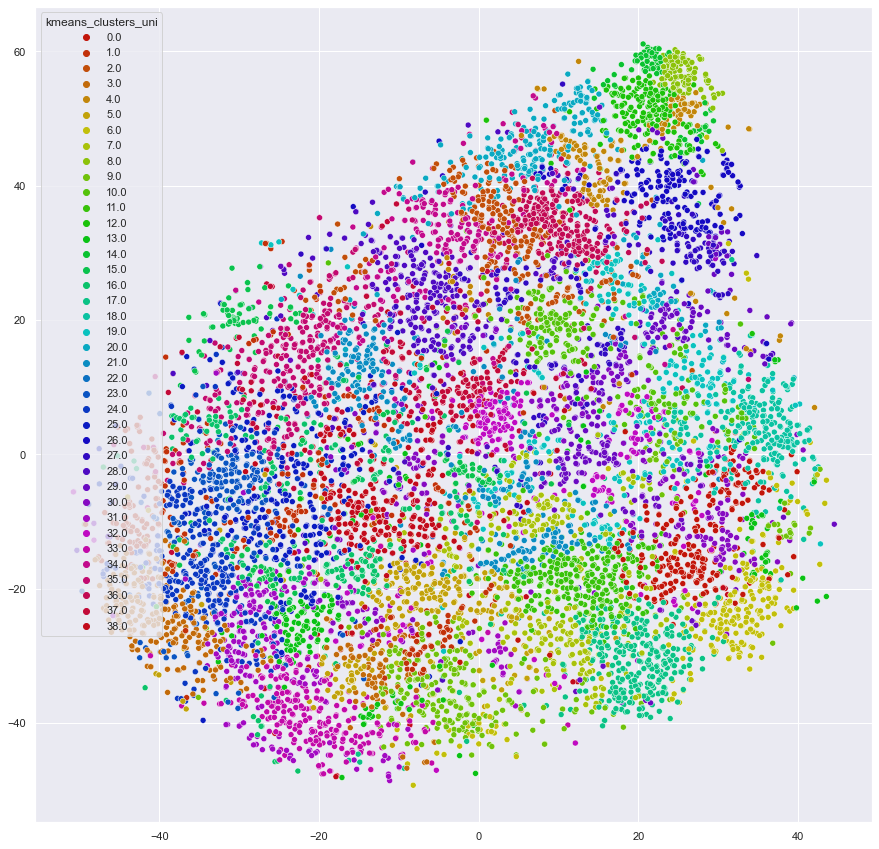

In [342]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})

palette = sns.hls_palette(k, l=.4, s=.9)

sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=df_combined.kmeans_clusters_uni.head(10000), palette=palette, legend='full')

In [327]:
# Check how successful the clustering was
y_labels = y_sub[:10000]
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_labels, y_pred))
print("Completeness: %0.3f" % metrics.completeness_score(y_labels, y_pred))
print("V-measure: %0.3f" % metrics.v_measure_score(y_labels, y_pred))

Homogeneity: 0.303
Completeness: 0.240
V-measure: 0.268


In [283]:
#Find nearest neighbours of a term
from scipy.spatial import distance
def findNearestNeighbour(term, vectors):
    term_vec = vectors[term]
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest



In [292]:
n = findNearestNeighbour('deep-neural-networks', vectors)
neighbourTerms = pd.DataFrame({n[0]:n[1:]})
n = findNearestNeighbour('computer-vision', vectors)
neighbourTerms[n[0]] = n[1:]
n = findNearestNeighbour('natural-language-processing', vectors)
neighbourTerms[n[0]] = n[1:]
n = findNearestNeighbour('algorithm', vectors)
neighbourTerms[n[0]] = n[1:]
n = findNearestNeighbour('machine-learning', vectors)
neighbourTerms[n[0]] = n[1:]

neighbourTerms

,deep-neural-networks,computer-vision,natural-language-processing,algorithm,machine-learning
0,dnns,natural-language-processing,nlp,method,deep-learning
1,dnn,nlp,computer-vision,algorithms,techniques
2,deep-learning,deep-learning,nlp-tasks,approach,tools
3,convolutional-neural-networks,image-processing,image-processing,iterative,approaches
4,neural-networks,machine-learning,biomedical,proposed,computer-vision
5,deep-learning-models,tasks,mathematics,optimal,machine-learning-models
6,architectures,applications,tasks,procedure,developed
7,machine-learning-models,recent-years,engineering,optimization,applications
8,cnns,image-classification,image-analysis,uses,frameworks


Silhouette Score for determining the best number of clusters

In [333]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2, 5, 10, 15, 20, 25, 30, 35, 38, 40, 45]

def silhouette(range_n_clusters):
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(np_vectors)

        silhouette_avg = silhouette_score(np_vectors, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )
silhouette(range_n_clusters)

For n_clusters = 2 The average silhouette_score is : 0.13211093029866214
For n_clusters = 5 The average silhouette_score is : 0.077247609793843
For n_clusters = 10 The average silhouette_score is : 0.06060925199809769
For n_clusters = 15 The average silhouette_score is : 0.05112084859150716
For n_clusters = 20 The average silhouette_score is : 0.04945374007148505
For n_clusters = 25 The average silhouette_score is : 0.048535959666171066
For n_clusters = 30 The average silhouette_score is : 0.04516794386164878
For n_clusters = 35 The average silhouette_score is : 0.04379310786628604
For n_clusters = 38 The average silhouette_score is : 0.04340805275927581
For n_clusters = 40 The average silhouette_score is : 0.04199412157940117
For n_clusters = 45 The average silhouette_score is : 0.041457779112541365


In [334]:
range_n_clusters = range(20,40,2)
silhouette(range_n_clusters)

For n_clusters = 20 The average silhouette_score is : 0.04945374007148505
For n_clusters = 22 The average silhouette_score is : 0.04831826770292513
For n_clusters = 24 The average silhouette_score is : 0.04760131119286429
For n_clusters = 26 The average silhouette_score is : 0.04609870189693869
For n_clusters = 28 The average silhouette_score is : 0.04614102253782091
For n_clusters = 30 The average silhouette_score is : 0.04516794386164878
For n_clusters = 32 The average silhouette_score is : 0.045560265236351156
For n_clusters = 34 The average silhouette_score is : 0.04358142359301064
For n_clusters = 36 The average silhouette_score is : 0.04350548297107848
For n_clusters = 38 The average silhouette_score is : 0.04340805275927581


In [335]:
range_n_clusters = [30,31,32,33]
silhouette(range_n_clusters)

For n_clusters = 30 The average silhouette_score is : 0.04516794386164878
For n_clusters = 31 The average silhouette_score is : 0.04504337412916748
For n_clusters = 32 The average silhouette_score is : 0.045560265236351156
For n_clusters = 33 The average silhouette_score is : 0.04365910420173696


Elbow method for determining the best number of clusters

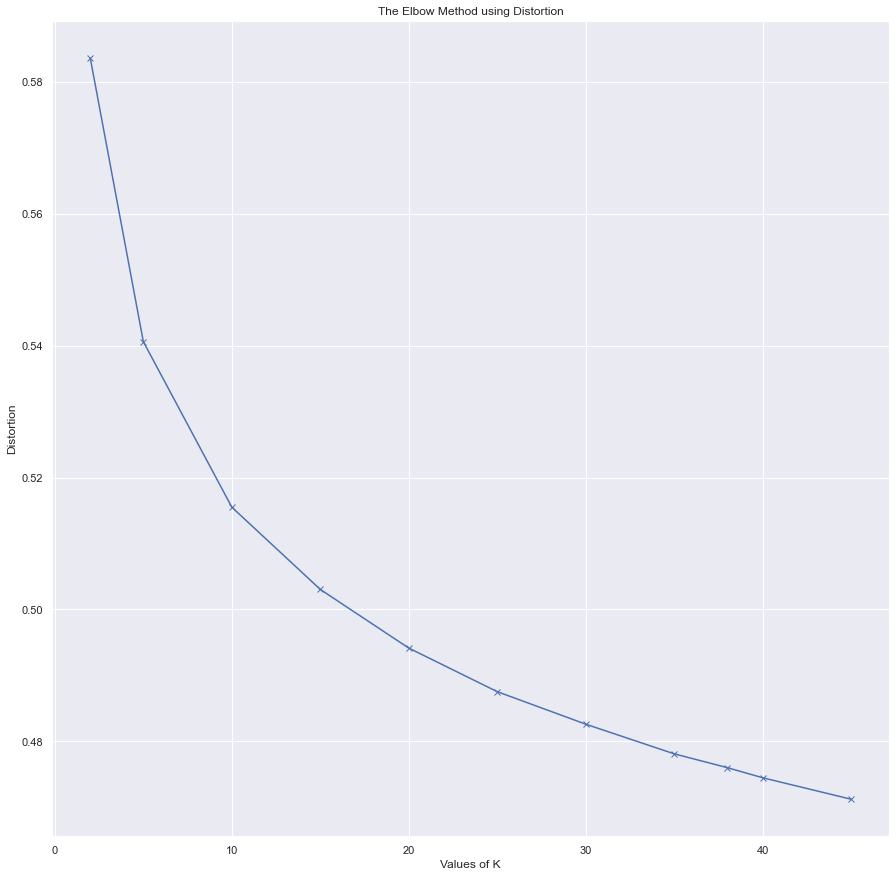

In [338]:
from sklearn import metrics
from scipy.spatial.distance import cdist

range_n_clusters = [2, 5, 10, 15, 20, 25, 30, 35, 38, 40, 45]

def elbow(range_n_clusters):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(np_vectors)

        distortions.append(sum(np.min(cdist(np_vectors, clusterer.cluster_centers_,
                                            'euclidean'), axis=1)) / len(np_vectors))
        inertias.append(clusterer.inertia_)
    
        mapping1[k] = sum(np.min(cdist(np_vectors, clusterer.cluster_centers_,
                                    'euclidean'), axis=1)) / len(np_vectors)
        mapping2[k] = clusterer.inertia_

    plt.plot(range_n_clusters, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()

elbow(range_n_clusters)

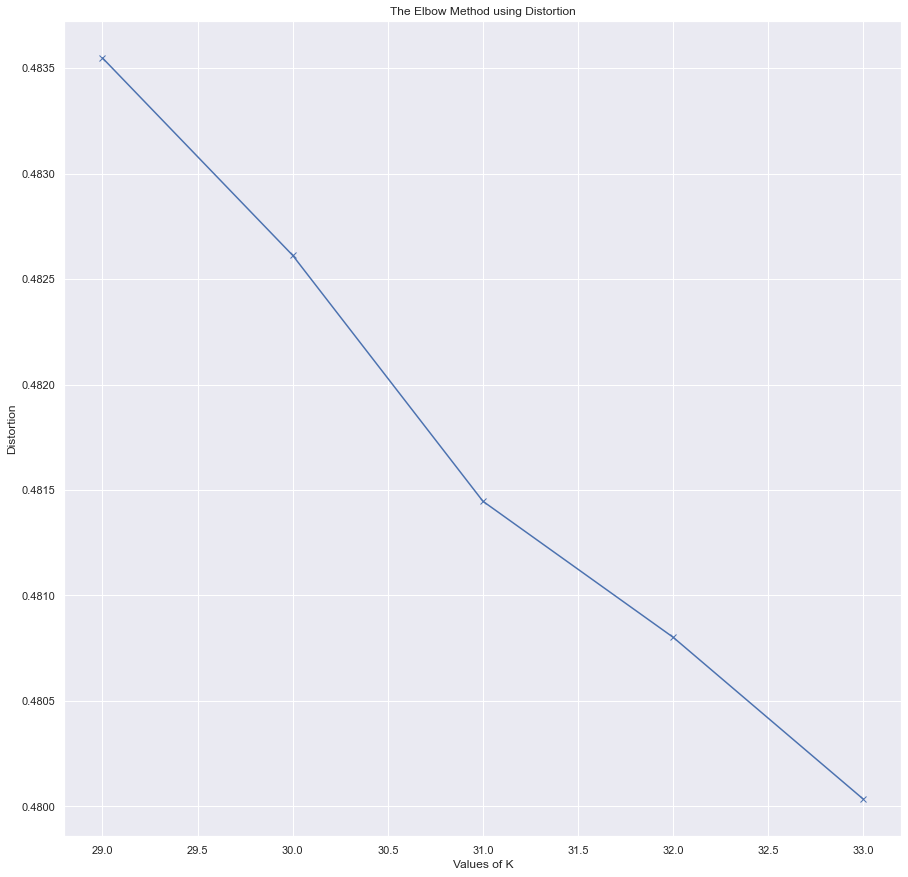

In [339]:
range_n_clusters = range(29, 34)
elbow(range_n_clusters)

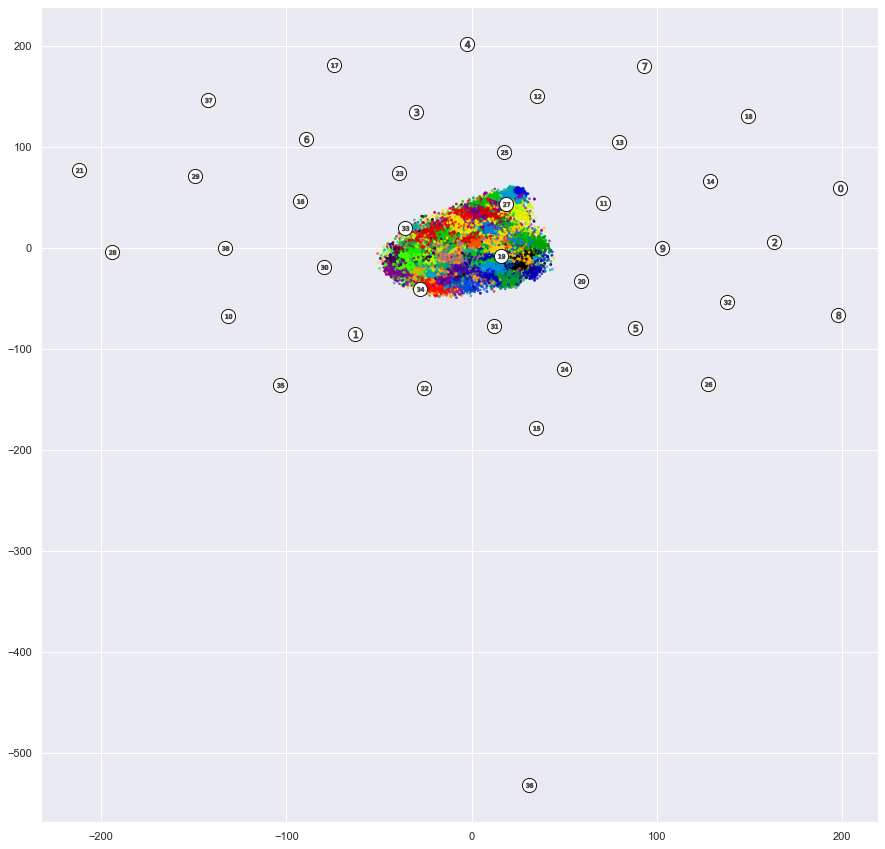

In [353]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=k, random_state=42)
cluster_labels = clusterer.fit_predict(np_vectors)
#tsne_results = tsne.fit_transform(np_vectors)
fig, (ax1) = plt.subplots(1, 1)

colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
ax1.scatter(
        tsne_results[:, 0], tsne_results[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

# Labeling the clusters
centers = clusterer.cluster_centers_
tsne_centers = tsne.fit_transform(centers)
# Draw white circles at cluster centers
ax1.scatter(
    tsne_centers[:, 0],
    tsne_centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(tsne_centers):
    ax1.scatter(c[0], c[1], marker="$%d$" % i, alpha=0.7, s=50, edgecolor="k")

In [370]:
for center in centers:
    for k,v in vectors.items():
        if(v.all == center.all):
            print(k)

In [386]:
def findNearestNeighbourVec(term_vec, vectors):
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest

In [391]:
n = findNearestNeighbourVec(centers[0], vectors)
neighbourTerms2 = pd.DataFrame({n[0]:n[1:]})
for i in range(1,6):
    n = findNearestNeighbourVec(centers[i], vectors)
    print(n)
    neighbourTerms2[n[0]] = n[1:]

neighbourTerms2

['addition', 'which', 'the', 'this', 'also', 'use', 'and', 'both', 'in', 'particular']
['addition', 'the', 'which', 'this', 'also', 'particular', 'of', 'is', 'both', 'and']
['addition', 'which', 'use', 'both', 'also', 'this', 'and', 'the', 'present', 'as']
['addition', 'which', 'also', 'this', 'particular', 'the', 'we', 'that', 'present', 'is']
['addition', 'also', 'this', 'use', 'and', 'which', 'present', 'both', 'as', 'in']


,addition
0,also
1,this
2,use
3,and
4,which
5,present
6,both
7,as
8,in
